Презентация:
[Ссылка на презентацию](https://disk.yandex.ru/i/UrbFAH04yrZRBw)

Необходимо построить дашборд в Tableau:
- Построить диаграмму, отражающую количество клиентов в зависимости от числа используемых продуктов.
- Добавить индикатор процента ушедших клиентов.
- Добавить фильтр дашборда по городу.

[Ссылка на дашборд Tableau](https://public.tableau.com/app/profile/aleksey6907/viz/ProjektBanksSergeevAS/Dashboard1?publish=yes "Дашборд финальный роект Сергеев Алексей")

## Описание проекта

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

## Цели и Задачи

- Необходимо проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.
- На основе исследования подготовить отчет в виде презентации, для принятия управленческих решений.

In [1]:
# Загрузим необходимые библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Тренировка и разделение
from sklearn.model_selection import train_test_split
# Стандартизация
from sklearn.preprocessing import StandardScaler

#from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage 

# Метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import itertools

# Импортируем библиотеки для сравнения долей

import math as mth
from scipy import stats as st

## Откроем и посмотрим на датасет, есть ли в нем отсутствующие или категорийные признаки

In [2]:
data = pd.read_csv('/datasets/bank_dataset.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

In [4]:
# Приведем название столбцов к нижнему регистру
data.columns = map(str.lower, data.columns)

In [5]:
# Сохраним датафрейм с учетом преобразования категорийных признаков
data = pd.get_dummies(data)

In [6]:
data.head()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,15677338,619,42,2,NaN,1,1,1,101348.88,1,0,0,1,1,0
1,15690047,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1,0
2,15662040,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1,0
3,15744090,699,39,1,NaN,2,0,0,93826.63,0,0,0,1,1,0
4,15780624,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1,0


## Проведем исследовательский анализ данных (EDA)
- Изучим средние значения и стандартные отклонения методом describe());
- Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался воспользуемся методом groupby());
- Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
- Построим матрицу корреляций и отобразим её, если будет сильная корреляция между несколькими переменными и это будет говорит о мультиколлениарности. Лучше всего избавляться от одной из таких переменных, чтобы наша модель работала объективно.

### Посмотрим на датасет: изучим средние значения и стандартные отклонения методом describe());

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,10000.0,1.573368e+07,71936.186123,15608437.00,1.567126e+07,1.573347e+07,1.579597e+07,15858426.00
score,10000.0,6.505288e+02,96.653299,350.00,5.840000e+02,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,3.200000e+01,3.700000e+01,4.400000e+01,92.00
objects,10000.0,5.012800e+00,2.892174,0.00,3.000000e+00,5.000000e+00,7.000000e+00,10.00
balance,6383.0,1.198275e+05,30095.056462,3768.69,1.001820e+05,1.198397e+05,1.395123e+05,250898.09
products,10000.0,1.530200e+00,0.581654,1.00,1.000000e+00,1.000000e+00,2.000000e+00,4.00
creditcard,10000.0,7.055000e-01,0.455840,0.00,0.000000e+00,1.000000e+00,1.000000e+00,1.00
loyalty,10000.0,5.151000e-01,0.499797,0.00,0.000000e+00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,5.100211e+04,1.001939e+05,1.493882e+05,199992.48
churn,10000.0,2.037000e-01,0.402769,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.00


### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался воспользуемся методом groupby());

In [8]:
data.groupby('churn').mean().T

churn,0,1
userid,1.573390e+07,1.573279e+07
score,6.518532e+02,6.453515e+02
age,3.740839e+01,4.483800e+01
objects,5.033279e+00,4.932744e+00
balance,1.195359e+05,1.207470e+05
products,1.544267e+00,1.475209e+00
creditcard,7.071455e-01,6.990673e-01
loyalty,5.545649e-01,3.608247e-01
estimated_salary,9.973839e+04,1.014657e+05
city_Ростов Великий,2.128595e-01,3.996073e-01


У тех кто остается выше:

- Более склонны уходить в отток с большим возрастом 
- Менее активные чаще уходят 
- Активные чаще остаются
- Чаще уходят в отток из Ростова
- Женщины чаще уходят в отток
- У тех, кто остается, баланс ниже

<div class="alert alert-info"><b>Комментарий студента:</b> 

Портрет клиента, который скорей всего уйдет в отток:
    
`Женщина` проживающая в `Ростове Великом`, возраст `44 года`, имеющая `5 объектов собственности`, кредитный скоринг `645 балов`, `не активный`, `баланс на карте` 120 747, зарплата 101 000.
</div>

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


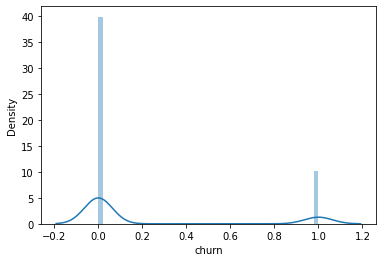

In [9]:
sns.distplot(data['churn']);

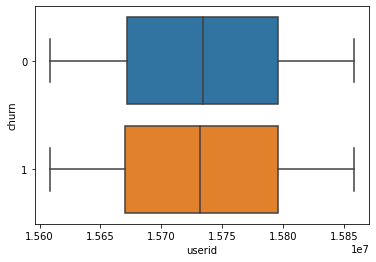

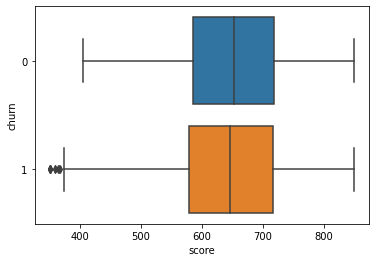

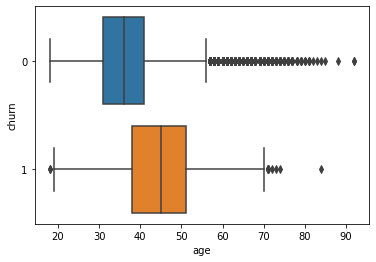

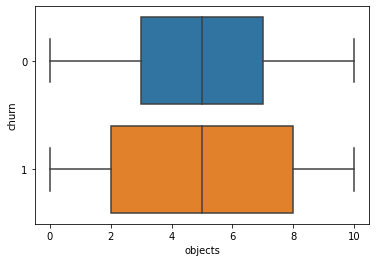

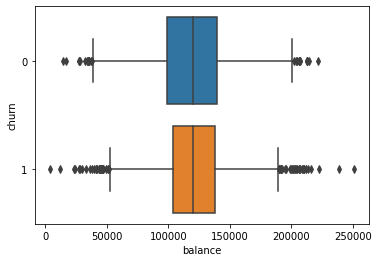

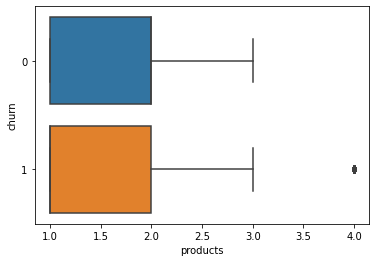

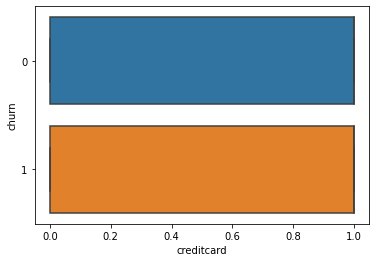

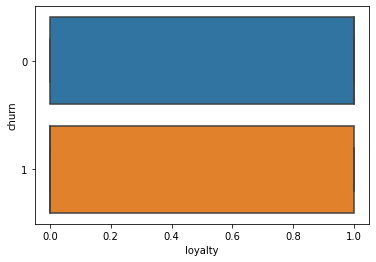

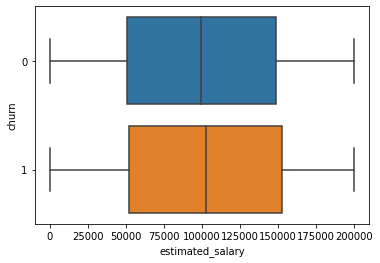

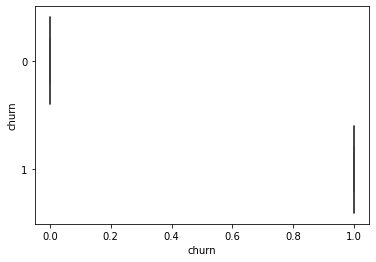

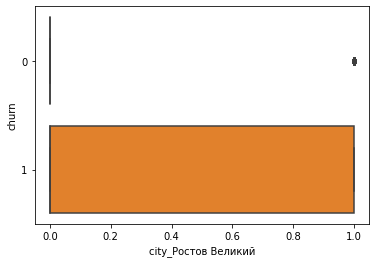

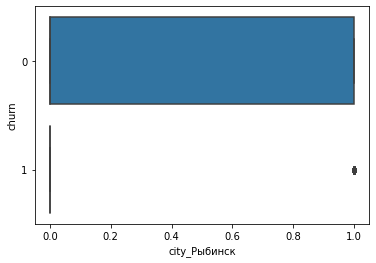

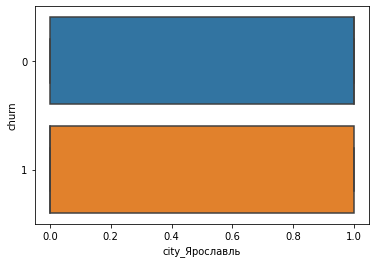

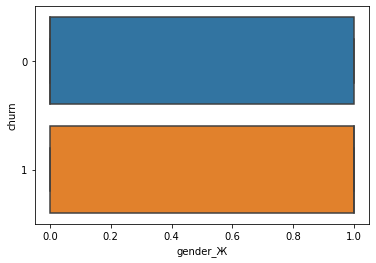

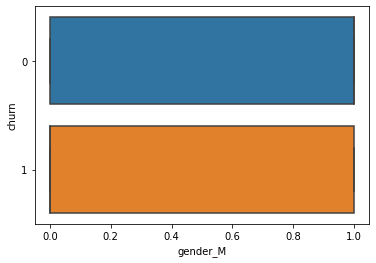

In [11]:
for col in data.columns:
    sns.boxplot(x=data[col], y='churn', data=data, orient='h') #ваш код здесь
    plt.show()

<div class="alert alert-info"><b>Вывод:</b> 
Заметны различия в `возрасте` и `количестве объектов собственности`.
    
- Уходят в отток в возрасте от 37 до 51 остаются от 30 до 41
- Количество объектов у тех кто уходит в отток от 2 до 8 у тех кто остается 3 до 7
</div>

In [12]:
data.groupby('churn').count()['userid']

churn
0    7963
1    2037
Name: userid, dtype: int64

Количество остающихся больше. 7963 кто остался, 2037 кто ушел в отток. В отток уходит 20% клиентов

### Построим матрицу корреляций и отобразим её.

Есть пропуске в Балансе, заменим их нолями, чтобы построить матрицу корреляции.

In [13]:
# Удалим столбец с Балансом
data = data.drop('balance', axis=1)

In [14]:
corr_m = data.corr()
#corr_m

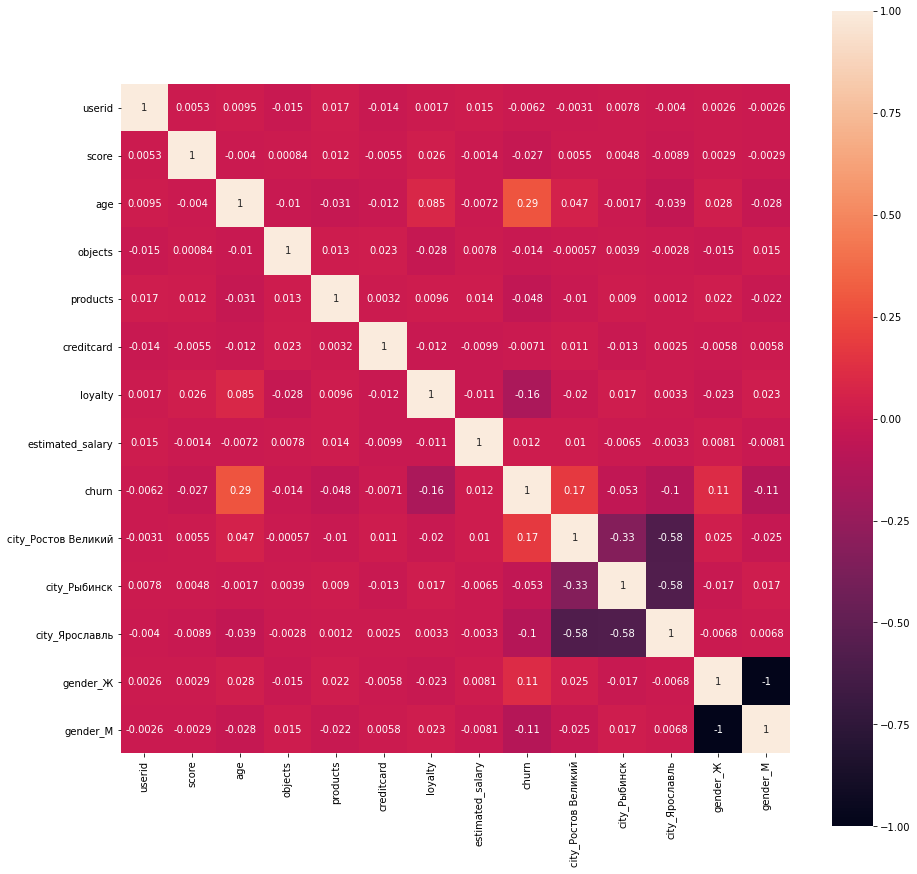

In [15]:
plt.figure(figsize = (15,15))
sns.heatmap(corr_m, square = True, annot = True)
plt.show()

Матрица корреляции показывает зависимость оттока от Возраста, женского пола, и города Ростов Великий.
Есть корреляция между балансом и городом Ростов Великий
Позже проверим эти зависимости.
Корреляции либо низкие, либо средние

##  Построим модель прогнозирования оттока клиентов
- Разобьём  данные на обучающую и валидационную выборку функцией train_test_split().
- Обучим модель на train-выборке двумя способами:
    - логистической регрессией
    - случайным лесом
- Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели, посмотрим какая модель показала себя лучше на основании метрик.

### Разобъем данные на обучающую и валидационную выборку функцией train_test_split().

In [16]:
X = data.drop('churn', axis = 1)
y = data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [17]:
# Функция печати метрик
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

### Обучим модель на train-выборке двумя способами:
#### логистической регрессией

In [18]:
# обучите StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [19]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear', random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

In [20]:
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_train, y_train)

predictions = lr_model.predict(X_test)
probabilities = lr_model.predict_proba(X_test)[:,1]

#### случайным лесом.

In [21]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test) # Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test)[:, 1] # Ваш код здесь

### Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?

In [22]:
# выведем все метрики для модели логистической регрессии
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.81
	Precision: 0.59
	Recall: 0.23
	F1: 0.33
	ROC_AUC: 0.76


In [23]:
# выведем все метрики модели случайного леса
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities, 
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.85
	Precision: 0.73
	Recall: 0.42
	F1: 0.53
	ROC_AUC: 0.82


In [24]:
importances = rf_model.feature_importances_
fi_df = pd.DataFrame(data={'feature': X.columns, 'importance': rf_model.feature_importances_})
fi_df.sort_values('importance', ascending=False)

,feature,importance
2,age,0.243544
7,estimated_salary,0.147048
0,userid,0.143878
1,score,0.142157
4,products,0.127069
3,objects,0.081911
6,loyalty,0.039664
8,city_Ростов Великий,0.020769
5,creditcard,0.017402
10,city_Ярославль,0.010247


На основании метрики модели `Случайного леса` показала себя немного лучше.

<div class="alert alert-info"><b>Вывод:</b> 
Так как recall в обоих моделях менее 50% на основе этих моделей прогнозирования оттока клиентов делать какието выводы не корретно.
</div>

## Сделаем кластеризацию клиентов

### Выделим портреты клиентов, которые склонны уходить из банка, сделаем кластеризацию клиентов


Отложите в сторону столбец с оттоком и проведите кластеризацию объектов (клиентов):

- Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
- Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
- Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока?
- Определим какие кластеры склонны к оттоку, а какие — надёжны?

### Стандартизируем данные

In [25]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположите, какое количество кластеров можно выделить.

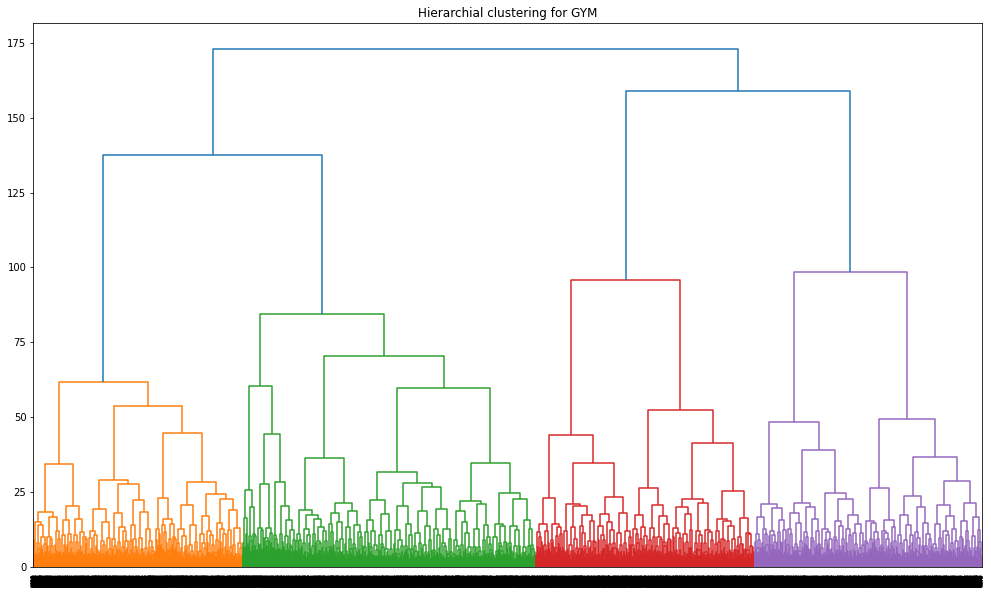

In [26]:
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(17, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

### Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. 

Можно выделит 8 кластеров

In [27]:
# задаём число кластеров, равное 8, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=8, random_state=0) 
# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc) 

### Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [28]:
data['cluster'] = labels

- Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
- Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

In [29]:
clusters = data.groupby(['cluster']).mean()
clusters

,userid,score,age,objects,products,creditcard,loyalty,estimated_salary,churn,city_Ростов Великий,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
cluster,,,,,,,,,,,,,,
0,1.573446e+07,651.769513,39.199265,5.000000,1.573003,0.707989,0.516988,100734.107475,0.212121,0,1,0,1,0
1,1.573521e+07,649.966565,39.424772,5.050152,1.527356,0.720365,0.523556,99905.033959,0.278116,1,0,0,0,1
2,1.573197e+07,647.645015,37.003021,5.131420,1.493202,0.716767,0.000000,100827.087054,0.169184,0,0,1,0,1
3,1.573117e+07,653.093881,40.154233,4.965633,1.511316,0.706622,0.468567,102446.424124,0.375524,1,0,0,1,0
4,1.573480e+07,650.992075,38.649135,5.057637,1.512968,0.684438,0.539625,98425.687680,0.131124,0,1,0,0,1
5,1.573554e+07,650.558935,38.826362,4.946134,1.541825,1.000000,0.513308,98589.948612,0.203422,0,0,1,1,0
6,1.573209e+07,652.306508,39.494752,4.973408,1.539538,0.710987,1.000000,99569.386886,0.088174,0,0,1,0,1
7,1.573388e+07,646.013177,38.653001,4.959004,1.560761,0.000000,0.515373,101815.280483,0.203514,0,0,1,1,0


Явных различиц в клатерах нет, уменьшим до 5.

In [36]:
# задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0) 
# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc)
data['cluster'] = labels
clusters = data.groupby(['cluster']).mean()
clusters.T

cluster,0,1,2,3,4
userid,1.573117e+07,1.573465e+07,1.573203e+07,1.573521e+07,1.573504e+07
score,6.530939e+02,6.513339e+02,6.500647e+02,6.499666e+02,6.491858e+02
age,4.015423e+01,3.889100e+01,3.829640e+01,3.942477e+01,3.877399e+01
objects,4.965633e+00,5.032297e+00,5.049401e+00,5.050152e+00,4.950022e+00
products,1.511316e+00,1.539362e+00,1.517254e+00,1.527356e+00,1.547545e+00
creditcard,7.066220e-01,6.947921e-01,7.137668e-01,7.203647e-01,6.979213e-01
loyalty,4.685666e-01,5.296730e-01,5.190701e-01,5.235562e-01,5.139319e-01
estimated_salary,1.024464e+05,9.944057e+04,1.001743e+05,9.990503e+04,9.956425e+04
churn,3.755239e-01,1.667340e-01,1.271340e-01,2.781155e-01,2.034498e-01
city_Ростов Великий,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00


По кластеризации получается, что в отток уходят женщины из Ростова Великого у них есть кредит, и возможно еще один продукт, проверим это.

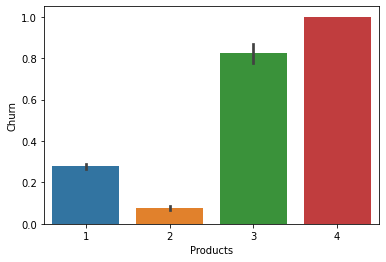

In [48]:
sns.barplot(x='Products', y='Churn', data=data_city);

In [49]:
data_city.query('Products == 2').pivot_table(index=['Churn'], values='userid', aggfunc='nunique')

,userid
Churn,
0,4242
1,348


Среди тех, кто ушел в отток вероятность того, что у клиента два продукта около 7%, поэтому у клиента который уходит в отток 1 продукт и это кредит.

Дополнительно построим сводную таблицу и проверим наши выводы относительно города и пола.

In [30]:
data_city = pd.read_csv('/datasets/bank_dataset.csv')

In [31]:
data_city.pivot_table(index=["Gender", 'Churn'], columns=['City'], values='userid', aggfunc=['count'])

count                  
City         Ростов Великий Рыбинск Ярославль
Gender Churn                                 
Ж      0                745     858      1801
       1                448     231       460
М      0                950    1206      2403
       1                366     182       350

Из сводных таблице видно, что в отток среди `женщин` в процентном отношении в выше, чем у `мужчин`, самый большой отток в `Ростове Великом`.

In [50]:
data_city.pivot_table(index=['Churn'], columns=['City'], values='userid', aggfunc=['count'])

count                  
City  Ростов Великий Рыбинск Ярославль
Churn                                 
0               1695    2064      4204
1                814     413       810

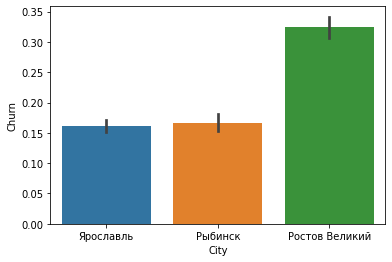

In [54]:
sns.barplot(x='City', y='Churn', data=data_city);

<div class="alert alert-info"><b>Вывод:</b>
Отток в Ростове Великом 32.4 % против 16% в других городах.
</div>

In [32]:
data_city.pivot_table(index=["Gender"], columns=['Churn'],values='userid', aggfunc=['count'])

count      
Churn      0     1
Gender            
Ж       3404  1139
М       4559   898

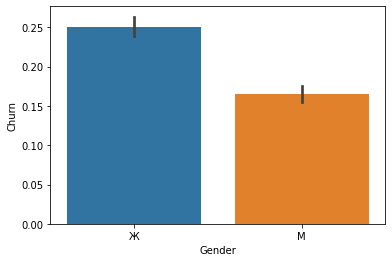

In [47]:
sns.barplot(x='Gender', y='Churn', data=data_city);

<div class="alert alert-info"><b>Комментарий студента V3 :</b>

График отображает доли оттока
    
Доля оттока среди женщин: 25 %
    
Доля оттока среди мужчин: 16 %    
</div>

<div class="alert alert-info"><b>Вывод:</b> 

    Портрет того кто уйдет в отток:
`С первого раза кластеризация не справилась с портретом клиента который уходит в отток, слишком маленькие различия` но навела на мысль, что отток  группируя по полу и месту жительства. 
    
Опытным путем остановился на `5-ти кластерах`, кластер отличается самым высоким скоренгом, самым большим возрастом самым большим доходом, и не лояльный

`Портрет`    
Женщина проживающая в Ростове Великом, возраст 40 лет, имеющая 5 объектов собственности, один продукт, скорей всего это кредит, кредитный скоринг 653 бала, не активный, зарплата 102 446.
    
    От портрета, полученного группировкой отличается `возрастом` и `скоренгом`.

Вывод: Человек становится клиентом, когда берет кредит, когда его выплачивает уходит в отток.
</div>

В матрице корреляции видно взаимосвязь между балансом и Ростовом Великим 

In [33]:
data_city.pivot_table( columns=['City'],values='Balance', aggfunc=['mean'])

mean                              
City    Ростов Великий        Рыбинск      Ярославль
Balance  119730.116134  119814.985923  119927.765597

Сводная таблица не показывает зависимости, баланса и города Ростов Великий, видимо корреляция появилась, когда мы заменили отсутсвующий баланс нолями.

In [34]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


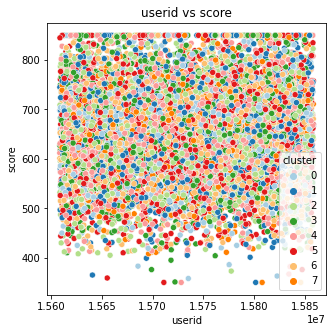

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


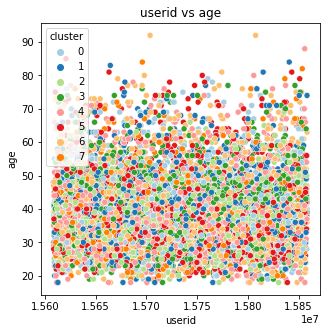

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


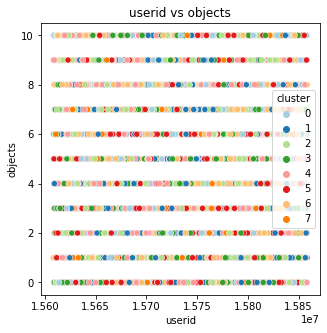

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


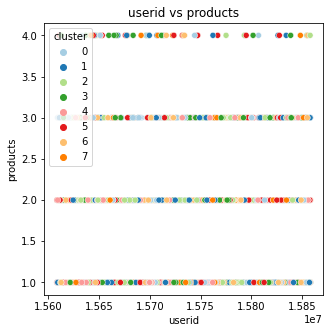

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


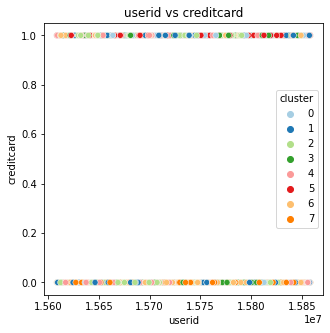

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


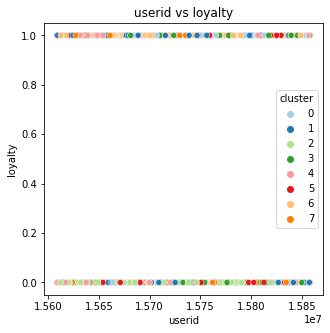

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


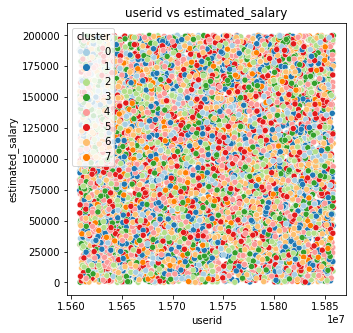

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


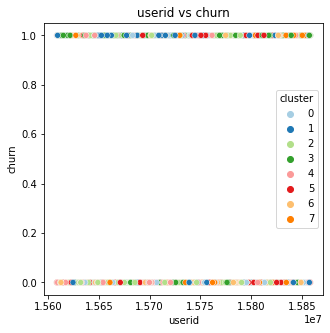

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


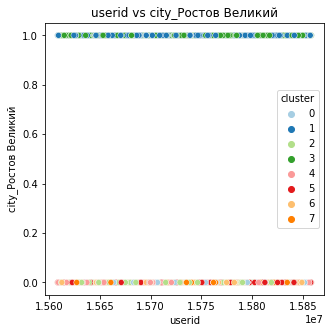

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


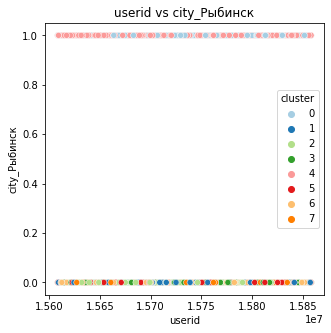

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


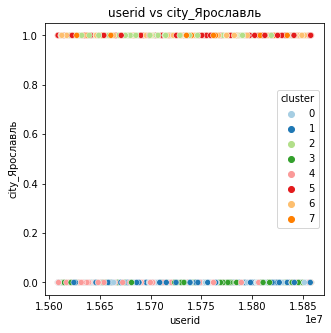

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


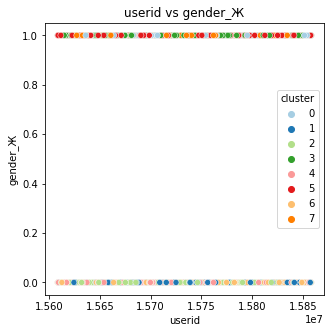

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


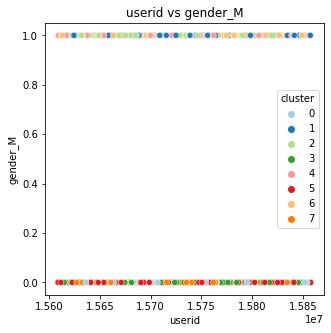

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


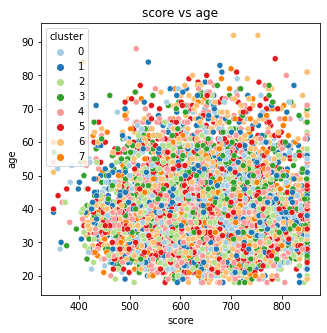

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


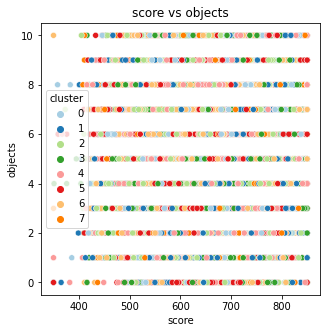

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


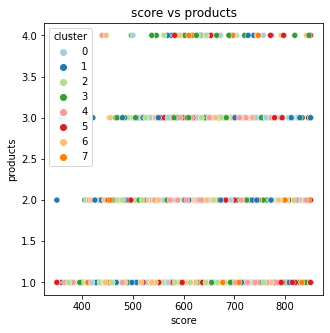

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


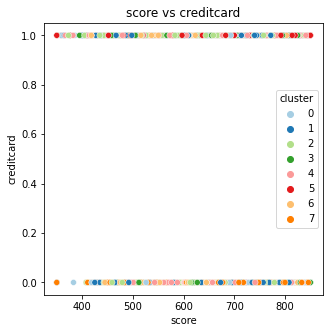

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


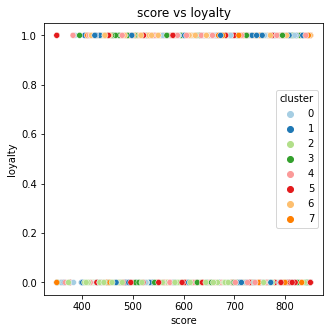

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


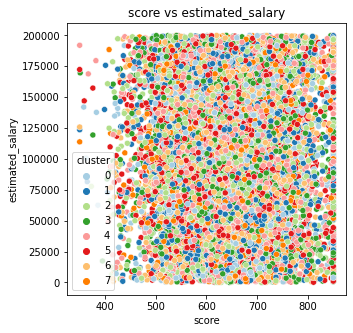

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


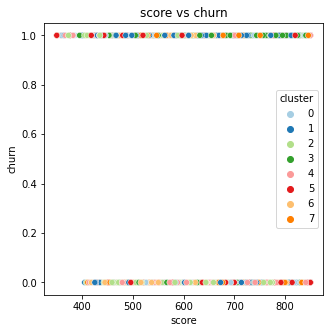

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


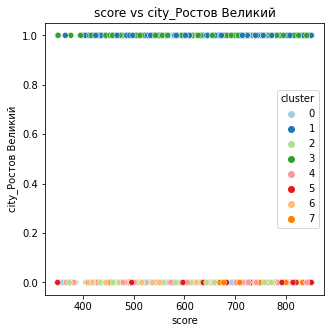

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


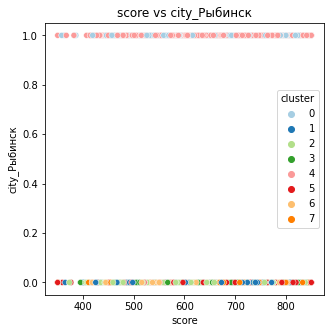

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


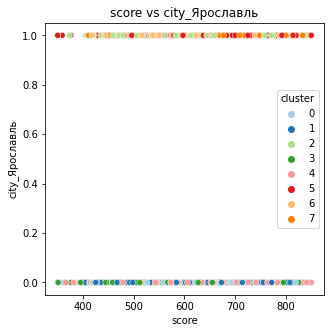

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


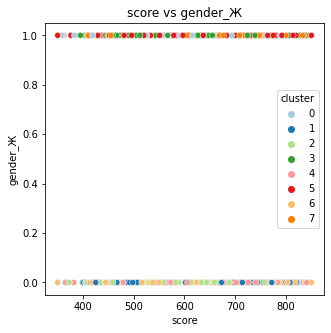

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


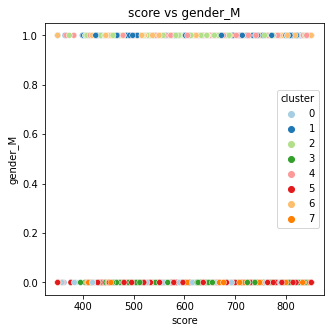

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


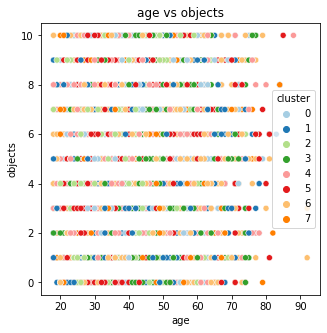

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


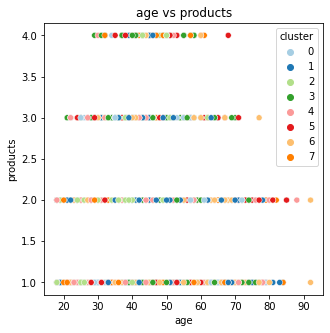

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


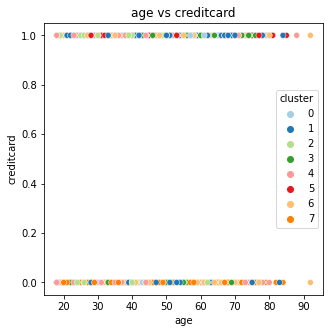

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


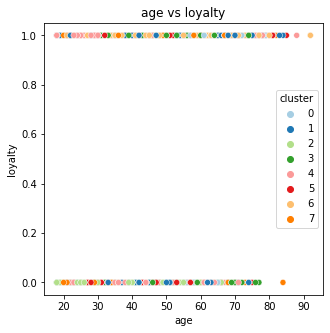

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


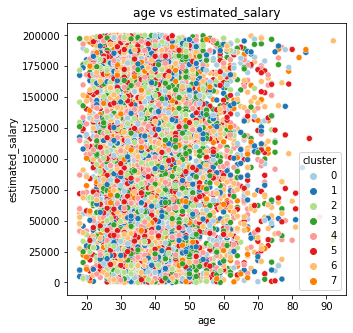

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


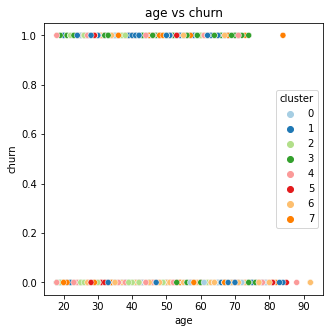

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


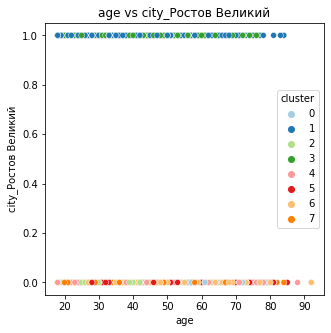

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


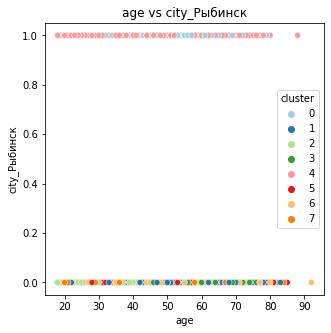

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


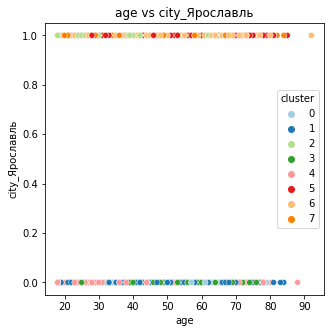

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


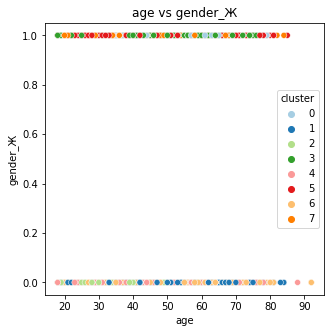

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


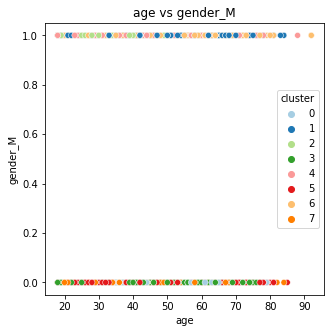

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


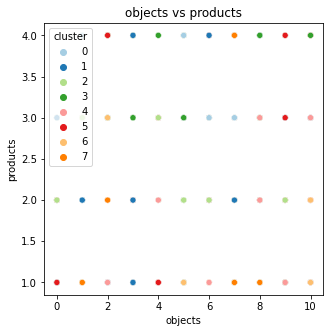

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


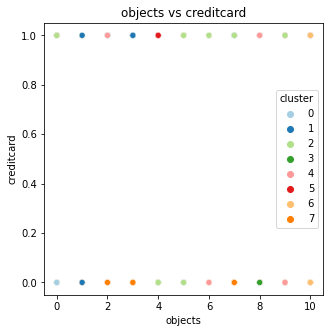

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


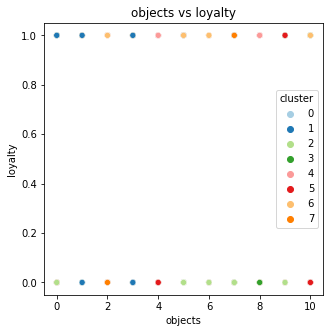

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


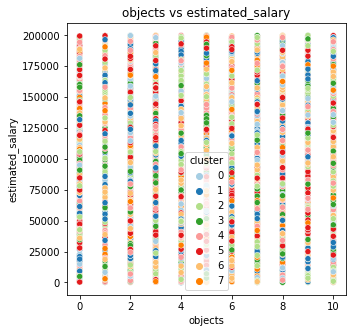

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


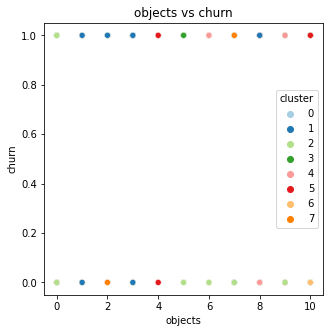

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


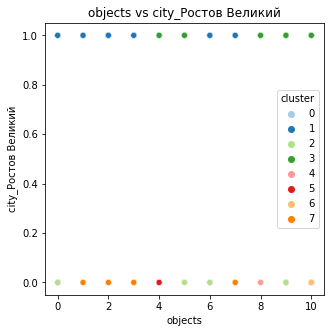

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


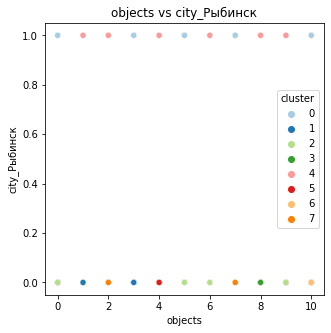

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


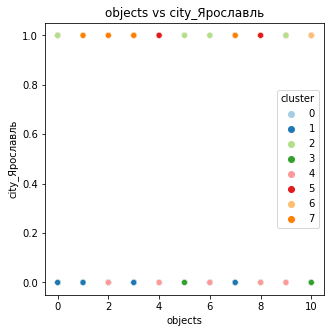

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


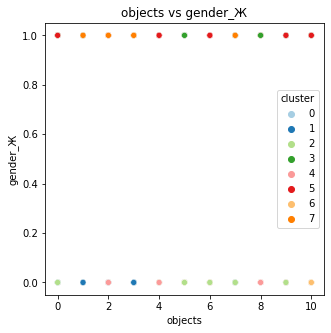

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


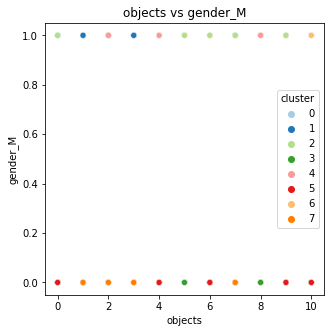

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


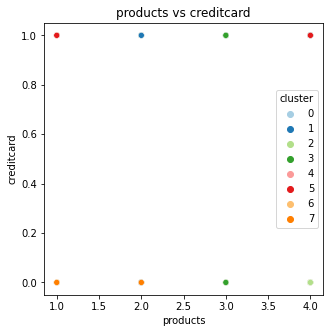

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


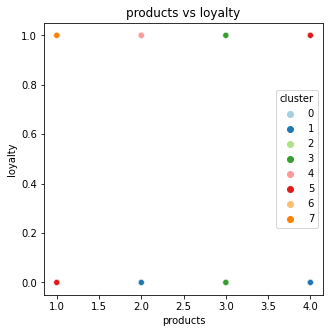

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


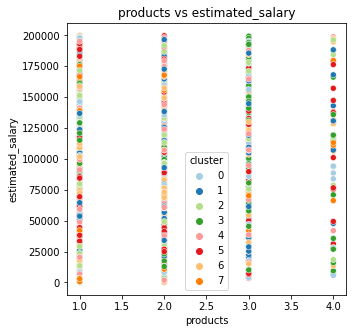

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


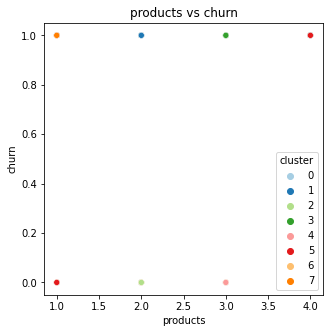

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


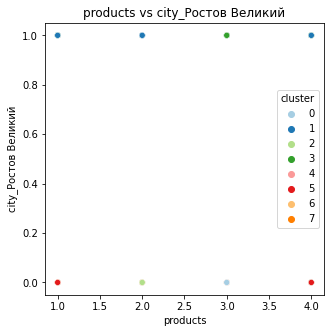

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


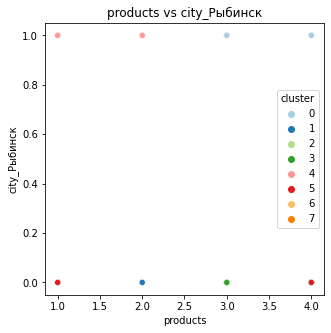

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


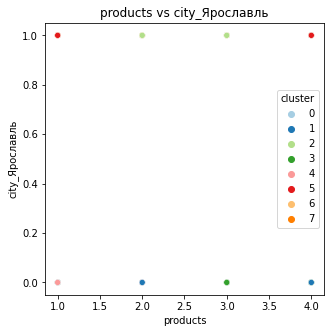

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


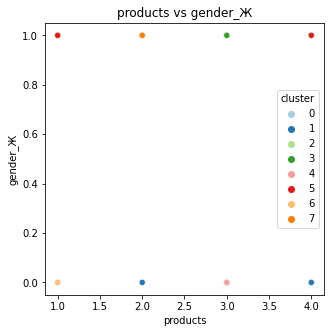

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


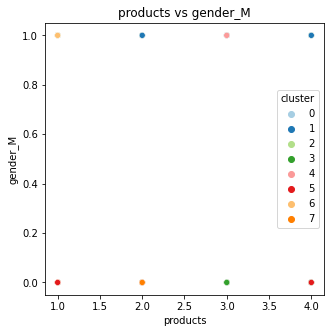

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


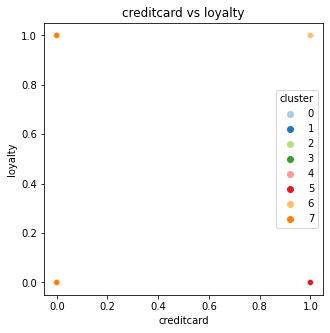

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


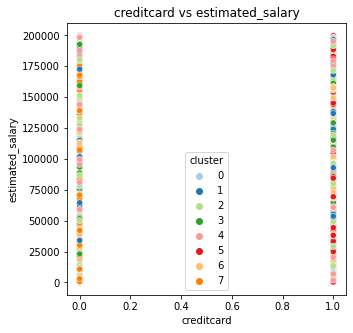

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


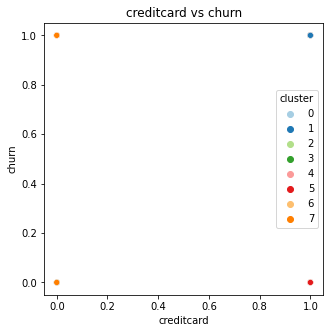

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


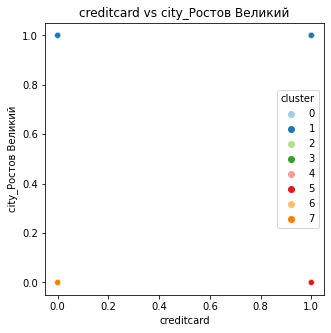

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


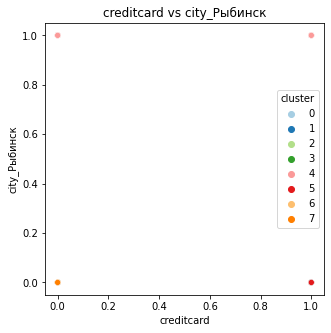

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


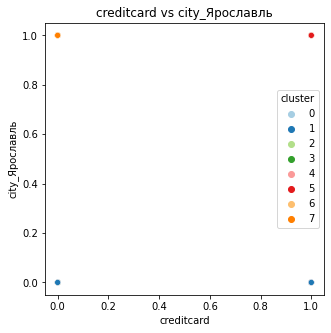

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


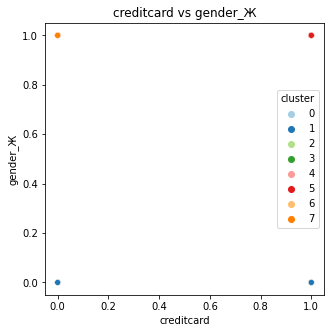

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


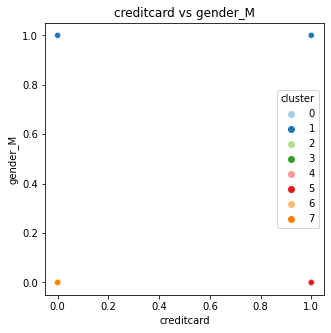

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


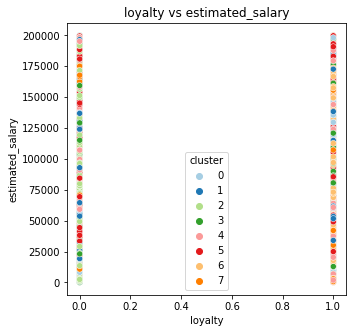

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


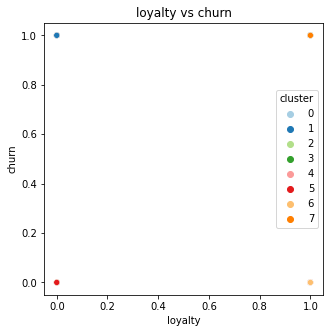

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


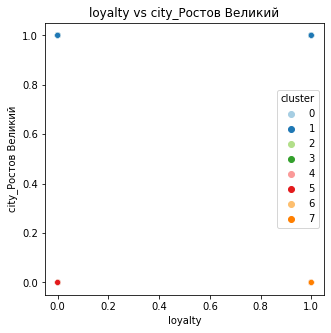

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


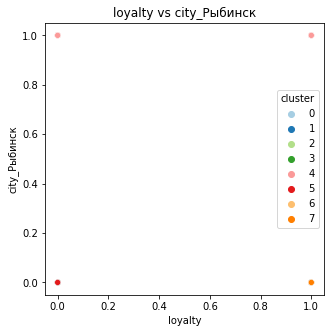

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


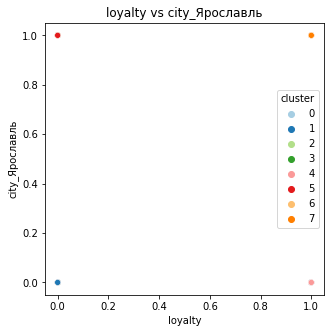

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


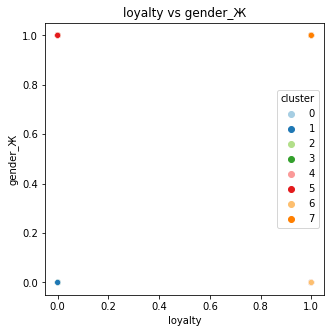

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


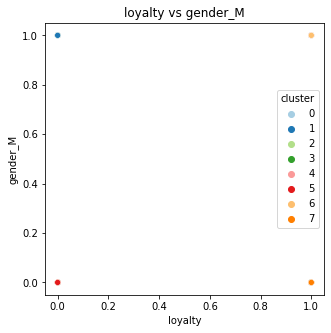

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


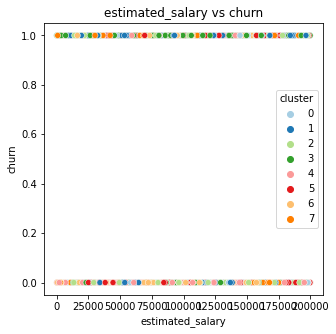

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


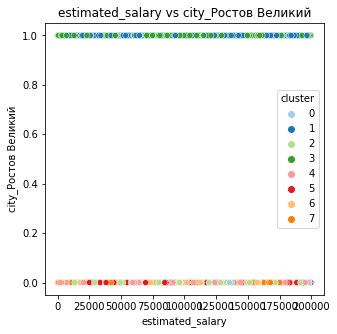

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


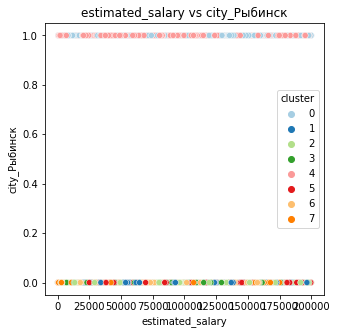

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


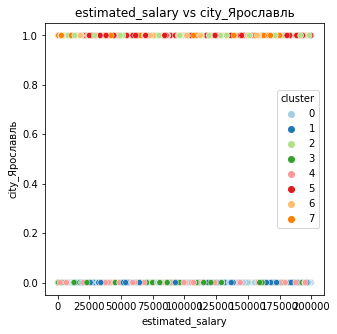

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


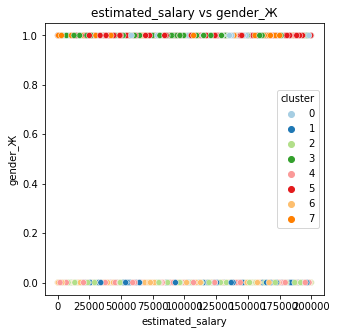

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


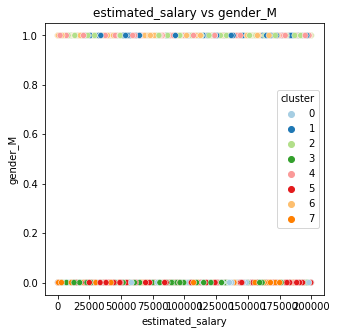

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


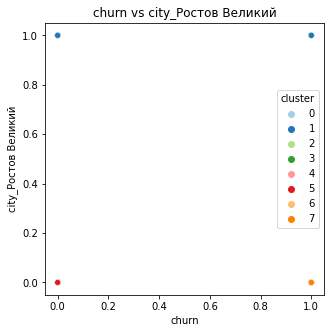

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


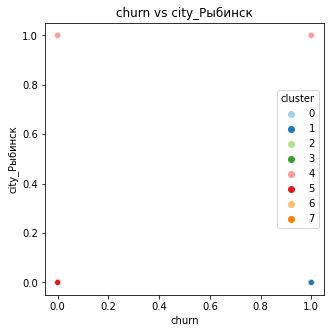

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


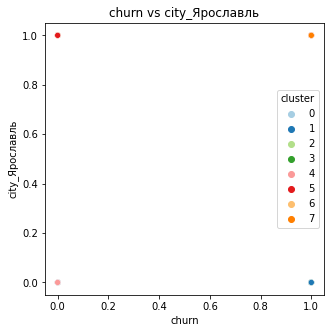

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


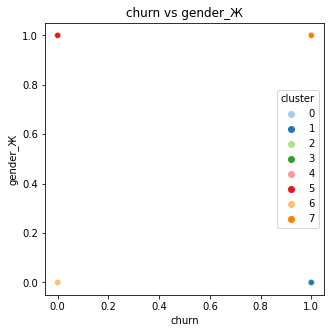

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


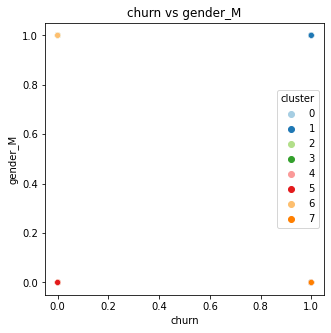

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


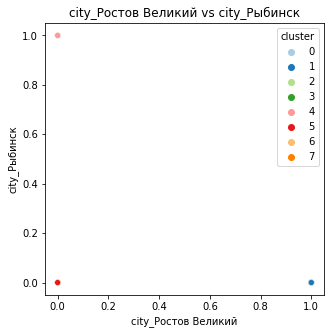

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


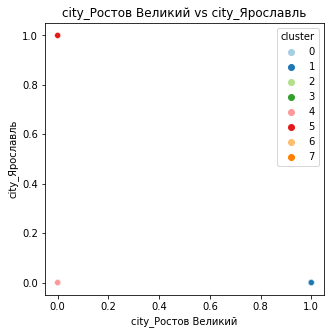

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


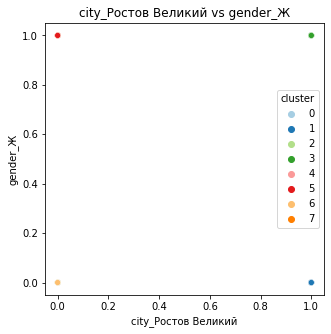

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


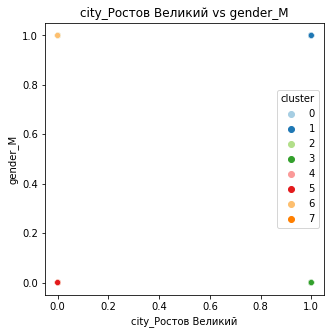

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


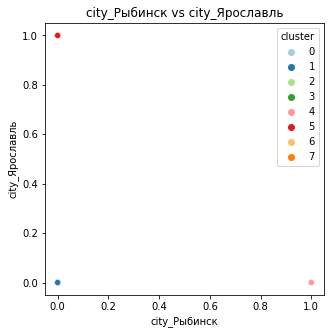

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


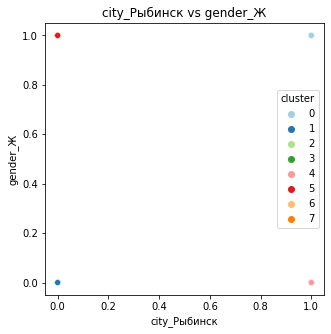

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


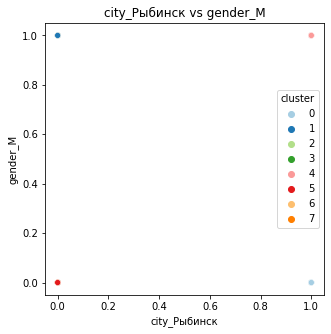

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


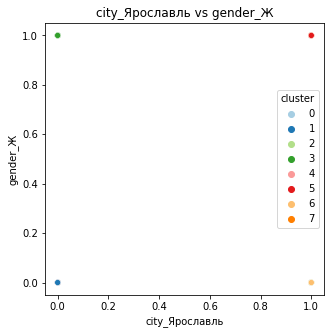

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


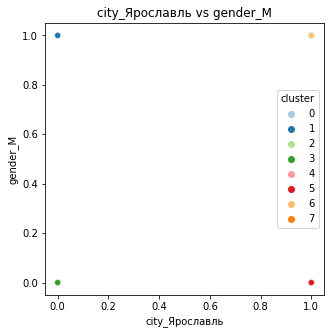

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


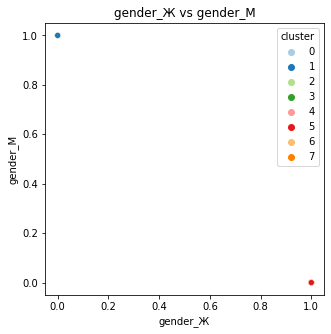

In [35]:
col_pairs = list(itertools.combinations(data.drop('cluster', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(data, pair[0], pair[1], 'cluster')   

Визуализировали все признаки по парно, но каких-то интересных зависимостей не заметил.

### Сформулируем и проверим статистические гипотезы.   

<div class="alert alert-info"><b>Комментарий студента:</b>
    
**Проверим гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.**
    
- H0 - нет различий размера дохода между теми клиентами, которые ушли и теми, которые остались 
- H1 - есть различия размера дохода между теми клиентами, которые ушли и теми, которые остались
    
</div>

In [37]:
churn_mean = data[data['churn'] == 1]['estimated_salary']
no_churn_mean = data[data['churn'] == 0]['estimated_salary']


alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results = st.ttest_ind(churn_mean, no_churn_mean, equal_var = False) # Дисперсия различается в три раза,
#укажем параметр equal_var = False

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.228924613051458
Не получилось отвергнуть нулевую гипотезу


Доход у тех кто ушел в отток и кто остался доход равный.

**Сформулируем и проверим статистическую гипотезу относительно представленных данных**

H0 - доли оттока женщин, не имеют статистически значимых различий.
    
H1 - в долях оттока женщин, есть статистически значимые различия.



Создадим сводные таблицы для анализа

In [38]:
data1 = data_city.pivot_table(index=['Churn'], values='userid',  aggfunc='nunique')
data1

,userid
Churn,
0,7963
1,2037


In [39]:
trials1 = data1['userid'].sum()
trials2 = data1.loc[1]

In [40]:
data2 = data_city.query('Gender == "Ж"').pivot_table(index=['Churn'], values='userid', aggfunc='nunique')
data2

,userid
Churn,
0,3404
1,1139


In [41]:
successes1 = data2['userid'].sum()
successes2 = data2.loc[1]

In [42]:
alpha=0.01

p1 = successes1/trials1
   
# пропорция успехов во второй группе:
p2 = successes2/trials2
    
    # пропорция успехов в комбинированном датасете:
p_combined = (successes1 + successes2) / (trials1 + trials2)
 
    # разница пропорций в датасетах
difference = p1 - p2 
 
   # считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 
    
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)
 
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

p-значение:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница


<div class="alert alert-info"><b>Вывод по гипотезам: </b>

- доход не различается у клиентов которые ушли в отток и у клиентов, которые остались. На этом параметре нет смысла сегментировать клиентов.
- Между долями оттока всех клиентов и долей оттока среди женщин есть разница, дополнительная проверка показала, что процент оттока среди женщин 25 %, а доля оттока среди мужчин 16 %.    
</div>

### Вывод и рекомендации отделу по работе с клиентами:

- В Ростове Великом меньше всего клиентов и больше всего клиентов уходят в отток. Скорей всего в этом городе есть конкурент, который предлагает более интересные условия.
Возможно, в Ростове Великом плохое обслуживание клиентов или большие очереди, или долгое обслуживание `стоит на это обратить внимание`.
- Мы выяснили, что если клиент женщина, то веоятность, что она уйдет в отток 25 %. Мужчины уходят в отток 16 %.
Скорей всего это тоже связано с условиями обслуживания, конкуренты предлагают более интересные условия. `Бонусы` и `скидки`.
Можно предложить повышенный кэшбэк в `магазинах косметики` или за операции `красота и уход`.
- клиенты уходят в отток после того, как завершат выплачивать кредит. Стоит в этот период предлагать дополнительные услуги.